# CNN2


Convolutional neuronal network with three conv layers.

First, we load the packages.



In [1]:
import pandas as pd
import numpy as np
from PIL import Image    
from sklearn.utils import shuffle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

from tqdm import tqdm_notebook

Then, we divide the data in train and validation (0.9 and 0.1). Also,we define the read function.

In [3]:
data = pd.read_csv("newdata.csv")
data = shuffle(data)
m = len(data)

train = data[1:int(m*0.9)]
val = data[(int(m*0.9) + 1):]

m_train = len(train)
m_val = len(val)

path = "train/" + train.iloc[1][1]+ ".tif"
img = cv2.imread(path) 
h_s = np.shape(img)[0]
v_s = np.shape(img)[1]
n_c = np.shape(img)[2]
def readimage(n_batch, n, X):
    batch = []
    for i in range(n):
        path = "train/" + X.iloc[i+n*n_batch]['id']+ ".tif"
        img = cv2.imread(path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        batch.append(np.moveaxis(img, -1,0))
        
    return torch.tensor(np.array(batch)).float()

Bath size: 29. <br>
Kernels_i: (m_conv_i,m_conv_i,c_conv_i). <br>
Stride of kernel: s_conv_i. <br>
Pool layer: Avg. 

In [4]:
batchsize = 29
n_batch = int(m_train / batchsize)

n_batchval = int(m_val / batchsize)

m_conv1 = 6 
n_conv1 = 15
s_conv1 = 2

m_pool1 = 4
s_pool1 = 1

m_conv2 = 5
n_conv2 = 20
s_conv2 = 2

m_pool2 = 4
s_pool2 = 2

m_conv3 = 3
n_conv3 = 30

m_pool3 = 3
s_pool3 = 1

m_conv4 = 3
n_conv4 = 40

m_pool4 = 2
s_pool4 = 1

m_fullyconnected = 2
l_rate = 0.001


Model: 

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #(3,96,96)
        self.conv1 = nn.Conv2d(3, n_conv1, m_conv1, s_conv1)
        #size (15, 46, 46)
        self.dropout = nn.Dropout(0.25)
        self.pool1 = nn.AvgPool2d(m_pool1,s_pool1)
        #size(15, 43, 43)
        self.conv2 = nn.Conv2d(n_conv1, n_conv2, m_conv2, s_conv2)
        #size (20,20, 20 )
        self.pool2 = nn.AvgPool2d(m_pool2, s_pool2)
        #size (20, 9, 9)
        self.conv3 = nn.Conv2d(n_conv2, n_conv3, m_conv3)
        #size (30, 7, 7 )
        self.pool3 = nn.MaxPool2d(m_pool3, s_pool3)
        #size (30, 5, 5)
        self.conv4 = nn.Conv2d(n_conv3, n_conv4, m_conv4)
        #size (40, 3, 3 )
        self.pool4 = nn.MaxPool2d(m_pool4, s_pool4)
        #size (40, 2, 2)
        self.fc1 = nn.Linear(n_conv4 * m_fullyconnected * m_fullyconnected,1)    
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(x.size(0), n_conv4 * m_fullyconnected * m_fullyconnected)
        x = self.fc1(x)
        return torch.sigmoid(x)
    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(1)
    
net=Net()
optimizer = optim.Adam(net.parameters(), lr=l_rate)
# create a loss function
criterion = nn.BCELoss()

Train:

In [6]:
train_loss = []
val_loss = []

for epoch in notebook.tqdm(range(100)):
    train = shuffle(train)
    batch_train_loss = 0
    for i in range(n_batch):
        data = readimage(i, batchsize,train)
        data = data/255
        data = torch.Tensor(data)
        target = torch.Tensor(train['label'][batchsize * i:batchsize * (i+1)].values)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out.view(batchsize,1), target.view(batchsize,1))
        loss.backward()
        optimizer.step()
        batch_train_loss += loss.item()
    train_loss.append(batch_train_loss / n_batch)
    batch_val_loss = 0
    for  k in range(n_batchval):
        data = readimage(k, batchsize, val)
        data = data/255
        target = torch.Tensor(val['label'][batchsize * k:batchsize * (k+1)].values)
        data, target = Variable(data), Variable(target)
        with torch.no_grad(): # 1) As do not want to update G 
            net_out = net(data) 
        batch_val_loss = batch_val_loss + (criterion(net_out.view(batchsize, 1), target.view(batchsize, 1)).item())
    val_loss.append(batch_val_loss / n_batchval)
    print(train_loss[epoch], val_loss[epoch], epoch)

C:\Users\Dani\anaconda3\envs\tfg\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0.4884361713202913 0.45784204750073615 0
0.4584821115898548 0.4565573755779493 1
0.442951340476235 0.46505512381685127 2
0.4239990822304662 0.40638473464819874 3
0.410841779089313 0.3944648524505482 4
0.40229161249485157 0.3909171224623368 5
0.3965161992168713 0.3796256191065255 6
0.39075306318077796 0.3850352577963416 7
0.3861788358682413 0.3870116358814579 8
0.3833227910273972 0.3767895158724294 9
0.37942714753283047 0.39725067576585155 10
0.3745297196607057 0.3708613531216782 11
0.37265266716475887 0.3660691872553649 12
0.3689828639371117 0.382876128420273 13
0.3662130815034055 0.37740194733625665 14
0.362952620991293 0.3967781517074731 15
0.36060412302591416 0.3926121951191438 16
0.35743959463326785 0.36437145025914136 17
0.35648675113741657 0.35245435936548464 18
0.35391500862973313 0.3569292207015064 19
0.3513823403621639 0.34723870548613783 20
0.3481181142029875 0.35257768237810966 21
0.3441717412963846 0.35670445006252277 22
0.344627004478272 0.33772226892863855 23
0.3436551058

Learning curve:

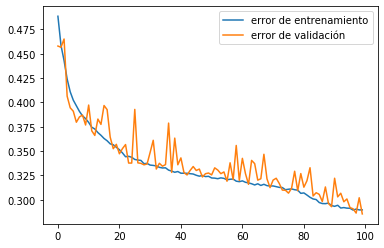

In [10]:
plt.plot(range(len(train_loss)), train_loss,label='error de entrenamiento')
plt.plot(range(len(val_loss)), val_loss, label='error de validación')
plt.legend(loc="upper right")


ROC curve:

AUC: 0.948
AUC NO SKILL: 0.500


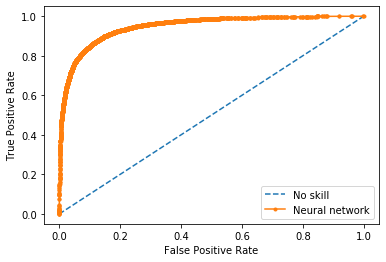

In [8]:
n_prob = [0 for _ in range(m_val)]
value = []
out = []
for  k in range(m_val):
        data = readimage(k, 1, val)
        data = data/255
        target = val['label'].values[k]
        data =  Variable(data)
        with torch.no_grad(): # 1) As do not want to update G 
            net_out = net(data) 
        value.append(target)
        out.append(net_out.item())
        
fpr1, tpr1, thresholds = roc_curve(value, out, pos_label = 1)
fpr2, tpr2, thresholds = roc_curve(value, n_prob, pos_label = 1)
auc1 = roc_auc_score(value, out)
auc2 = roc_auc_score(value, n_prob)


print('AUC: %.3f' % auc1)
print('AUC NO SKILL: %.3f' % auc2)
pyplot.plot(fpr2, tpr2, linestyle='--', label='No skill')
pyplot.plot(fpr1, tpr1, marker='.', label='Neural network')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

Examples of kernels:

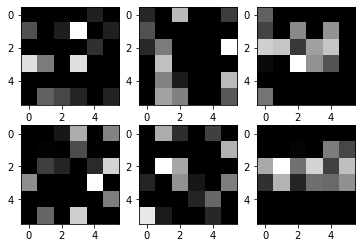

In [11]:
kernels = F.relu(net.conv1.weight.detach())
fig, axarr = plt.subplots(2,3)
for idx in range(2):
    for j in range(3):
        axarr[idx,j].imshow(kernels[idx+j].view(6,6,-1)[:,:,j],cmap='gray')

Save in csv test values:

In [35]:
test = pd.read_csv("sample_submission.csv")
def readtest(n_batch, n):
    batch = []
    for i in range(n):
        path = "test/" + test.iloc[i+n*n_batch]['id']+ ".tif"
        img = cv2.imread(path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        batch.append(np.moveaxis(img, -1,0))
        
    return torch.tensor(np.array(batch)).float()

In [41]:
preds=[]
batchtest = 28729
for i in range(batchtest):
    data = readtest(i,2)
    data = data/255
    data =  Variable(data)
    with torch.no_grad(): # 1) As do not want to update G 
         net_out = net(data) 
    preds.append(net_out)


In [79]:
target=[]
for i in range(batchtest):
    target.append(preds[i][0].item())
    target.append(preds[i][1].item())


In [81]:
submission = pd.DataFrame({'id':test['id'],'label':target})

submission.head()
filename = 'prediction_test.csv'
submission.to_csv(filename,index=False)

In [67]:
len(test)

57458